# Part 3: Computer Vision and Artificial Intelligence

Main tasks: Implement a Convolutional Neural Network (CNN) on the CIFAR-10 dataset and solve the following three problems using pytorch.

### Importing Necessary Libraries

In [1]:
import torch
import torch.optim as optim
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

### Set to use GPU (if available)

In [2]:
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using GPU, device name: Tesla T4


## Setting Up

### Load CIFAR-10 Dataset

In [3]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Checking dataset
train_size = len(train_dataset)
test_size = len(test_dataset)
classes = train_dataset.classes

print(f"Training Dataset Size: {train_size}")
print(f"Test Dataset Size: {test_size}")
print(f"Classes: {classes}")

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training Dataset Size: 50000
Test Dataset Size: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Splitting Data into Training, Validation and Test Sets

In [4]:
# Define the validation set
val_split = 5000
train_split = len(train_dataset) - val_split

train_data, val_data = random_split(train_dataset, [train_split, val_split])

# Creating data loaders
batch_size = 128 # Setting batch size parameter for training
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_data), len(val_data), len(test_dataset)


(45000, 5000, 10000)

### Define the CNN Architecture (Without Batch Normalization)
- 3 Convolutional Layers
- 3 Fully Connected Layers


The choice of using dropout as a regularization technique in this model was inspired by an article by Jason Brownlee [How to Develop a CNN from Scratch for CIFAR-10 Photo Classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/). In his experiment, he demonstrated that applying dropout after each MaxPooling layer can result in a 10% improvement in accuracy.

In [5]:
class ConvNet(nn.Module):
    def __init__(self, imgHeight, imgWidth, categories):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25) # Setting regularization technique dropout for parameter

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * (imgHeight // 8) * (imgWidth // 8), 256)
        self.dropout_fc1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 128)
        self.dropout_fc2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, categories)
        self.dropout_fc3 = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        # Flatten all batches except batch
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)
        x = self.fc3(x)

        return x

# Parameters for CIFAR-10 dataset
imgHeight, imgWidth, categories = 32, 32, 10

# Instantiate model
model = ConvNet(imgHeight, imgWidth, categories).to(device)
print(model)


ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (dropout_fc1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout_fc2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout_fc3): Dropout(p=0.25, inplace=False)
)


### Testing Initial Performance Before Training

In [6]:
def evaluate(model, val_loader, loss_fun):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs, targets)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total
    return {'val_loss': val_loss, 'val_acc': val_acc}

# Instantiate model
model = ConvNet(imgHeight=32, imgWidth=32, categories=10).to(device)

# Define loss function
loss_fun = nn.CrossEntropyLoss()

# Evaluate model on validation set
initial_eval = evaluate(model, val_loader, loss_fun)
print(f"Initial Validation Loss: {initial_eval['val_loss']:.4f}")
print(f"Initial Validation Accuracy: {initial_eval['val_acc']:.4f}")

Initial Validation Loss: 2.3033
Initial Validation Accuracy: 0.1008


## Training Without Batch Normalization

To implement this code, I referred to various resources for guidance. For the evaluate function and the overall training model, I utilized Practical 2 of the CSC3831 module as well as the tutorial from [Kaggle](https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch#Training-the-Model). For the implementation of early stopping, I was inspired by the GitHub repository of [Will Koehrsen](https://github.com/WillKoehrsen/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/cifar10_cnn_solution.ipynb).

In [ ]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 50
patience = 10
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# Track training classificaiton accuracy
def correct(output, target):
    pred = output.argmax(dim=1)
    correct_pred = (pred == target).type(torch.float)
    return correct_pred.sum().item()

# Training function with validation sets
def train_with_validation(train_loader, val_loader, model, loss_fun, optimizer, num_epochs):
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    # Variables required for Early Stopping implementation
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)

            # Calculate the loss
            loss = loss_fun(output, target)
            total_loss += loss.item()

            # Calculate correct predictions
            total_correct += correct(output, target)
            total_samples += target.size(0)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Training metrics
        train_loss = total_loss / len(train_loader)
        train_acc = total_correct / total_samples
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation phase
        val_metrics = evaluate(model, val_loader, loss_fun)
        val_loss = val_metrics['val_loss']
        val_acc = val_metrics['val_acc']
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Check improvement on validation loss (Early Stopping)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict() # Saving the best model
            patience_counter = 0
            print(f"Validation loss improved to {val_loss:.4f}, saving model...")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

        # Early stopping condition
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the best model
    if best_model_state is not None:
        torch.save(best_model_state, "best_model.pth")
        print("Best model saved as 'best_model.pth'.")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_with_validation(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    loss_fun=loss_fun,
    optimizer=optimizer,
    num_epochs=num_epochs
)


### Plotting Convergence Graph Between Training and Validation Loss (over a predefined number of epochs)

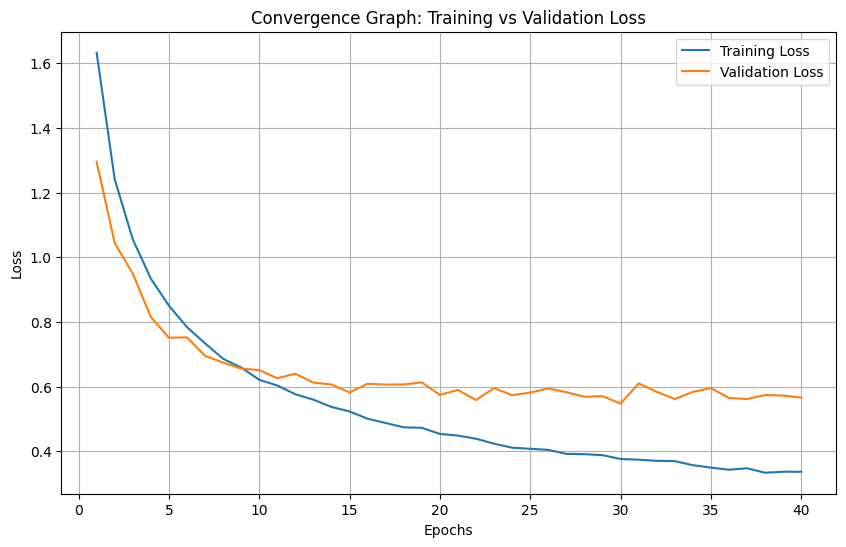

In [33]:
plt.figure(figsize=(10, 6))

# Defining number of epochs
epochs = range(1, len(train_loss_history) + 1)

# Plotting training and validation loss graph
plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Convergence Graph: Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Show graph
plt.show()


## CNN Design Architecture (With Batch Normalization)

- 3 Convolutional Layers
- 3 Fully Connected Layers
- 3 Batch Normalization

In [6]:
class ConvNetWithBatchNorm(nn.Module):
    def __init__(self, imgHeight, imgWidth, categories):
        super().__init__()

        # adding batch normalization in each convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * (imgHeight // 8) * (imgWidth // 8), 256)
        self.dropout_fc1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 128)
        self.dropout_fc2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, categories)
        self.dropout_fc3 = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        # Flatten all batches except batch
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)
        x = self.fc3(x)

        return x

# Parameters for CIFAR-10
imgHeight, imgWidth, categories = 32, 32, 10

# Instantiate model with batch normalization
model_with_bn = ConvNetWithBatchNorm(imgHeight, imgWidth, categories).to(device)
print(model_with_bn)

ConvNetWithBatchNorm(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (dropout_fc1): Dro

### Training with Batch Normalization

In [45]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 50
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_with_bn.parameters(), lr=0.001, weight_decay=1e-4)


# Track training classification accuracy
def correct(output, target):
    pred = output.argmax(dim=1)
    correct_pred = (pred == target).type(torch.float)
    return correct_pred.sum().item()


# Training function for CNN with batch normalization
def train_bn(train_loader, val_loader, model, loss_fun, optimizer, num_epochs, save_path):
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []
    best_val_loss = float('inf')
    best_model_path = save_path

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = loss_fun(output, target)
            total_loss += loss.item()

            # Calculate correct predictions
            total_correct += correct(output, target)
            total_samples += target.size(0)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Training metrics
        train_loss = total_loss / len(train_loader)
        train_acc = total_correct / total_samples
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_samples = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = loss_fun(output, target)
                val_loss += loss.item()
                val_correct += correct(output, target)
                val_samples += target.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_samples
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Finding the best model based on validation loss (similar to previous model)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Validation loss improved to {val_loss:.4f}, saving model...")

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Saving best model with batch normalization
best_model_path = "best_model_bn.pth"

train_loss_bn, train_acc_bn, val_loss_bn, val_acc_bn = train_bn(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model_with_bn,
    loss_fun=loss_fun,
    optimizer=optimizer,
    num_epochs=num_epochs,
    save_path=best_model_path
)

Best model saved at epoch 1 with validation loss: 1.0828
Epoch 1/50, Train Loss: 1.5037, Train Accuracy: 0.4460, Validation Loss: 1.0828, Validation Accuracy: 0.5984
Best model saved at epoch 2 with validation loss: 0.9397
Epoch 2/50, Train Loss: 1.1249, Train Accuracy: 0.5986, Validation Loss: 0.9397, Validation Accuracy: 0.6666
Best model saved at epoch 3 with validation loss: 0.8208
Epoch 3/50, Train Loss: 0.9928, Train Accuracy: 0.6523, Validation Loss: 0.8208, Validation Accuracy: 0.7054
Best model saved at epoch 4 with validation loss: 0.7883
Epoch 4/50, Train Loss: 0.8918, Train Accuracy: 0.6904, Validation Loss: 0.7883, Validation Accuracy: 0.7180
Best model saved at epoch 5 with validation loss: 0.7179
Epoch 5/50, Train Loss: 0.8258, Train Accuracy: 0.7136, Validation Loss: 0.7179, Validation Accuracy: 0.7468
Epoch 6/50, Train Loss: 0.7842, Train Accuracy: 0.7284, Validation Loss: 0.7249, Validation Accuracy: 0.7390
Best model saved at epoch 7 with validation loss: 0.6460
Epoc

### Plotting Convergence Graph With and Without Batch Normalization

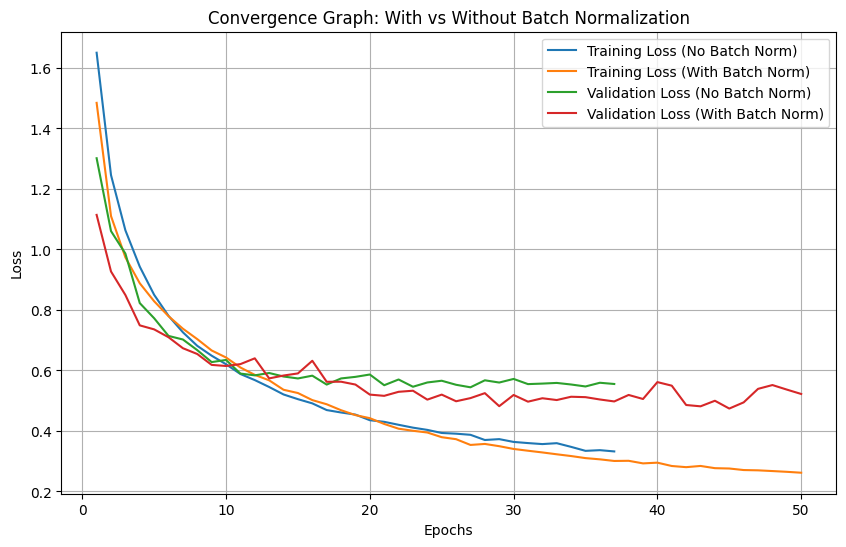

In [16]:
plt.figure(figsize=(10, 6))

# Defining number of epochs for both models
epochs_no_bn = range(1, len(train_loss_history) + 1)
epochs_with_bn = range(1, len(train_loss_bn) + 1)

# Comparison for Training Loss
plt.plot(epochs_no_bn, train_loss_history, label="Training Loss (No Batch Norm)")
plt.plot(epochs_with_bn, train_loss_bn, label="Training Loss (With Batch Norm)")

# Comparison for Validation Loss
plt.plot(epochs_no_bn, val_loss_history, label="Validation Loss (No Batch Norm)")
plt.plot(epochs_with_bn, val_loss_bn, label="Validation Loss (With Batch Norm)")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Convergence Graph: With vs Without Batch Normalization")
plt.legend()
plt.grid(True)

# Show the graph
plt.show()


## Visualization

### Visualize Convolutional Features / Filters

<ipython-input-8-c33e0b4dcdf8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_with_bn.load_state_dict(torch.load("best_model_bn.pth"))


Visualizing Filters (Kernels) for First Convolutional Layer:


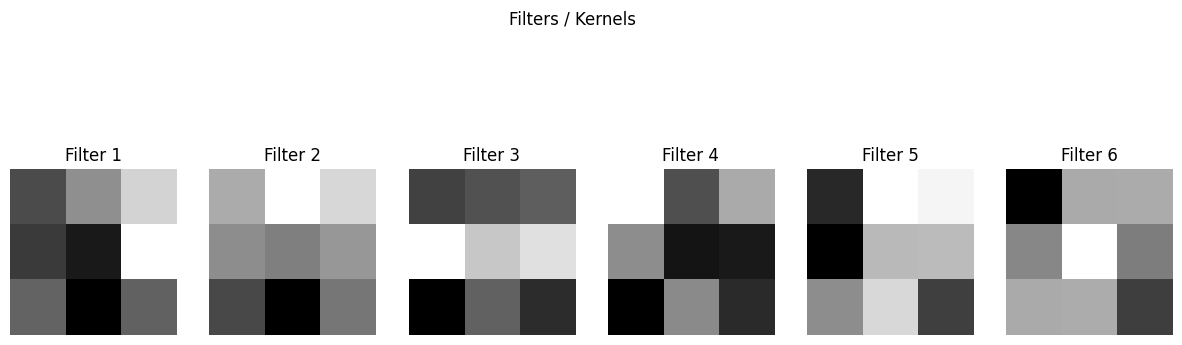

In [8]:
# Choosing model with batch normalization
model_with_bn = ConvNetWithBatchNorm(imgHeight=32, imgWidth=32, categories=10).to(device)

# Load the best model with batch normalization
model_with_bn.load_state_dict(torch.load("best_model_bn.pth"))
model_with_bn.eval()

def visualize_filters(layer, num_filters=6):
    filters = layer.weight.data.cpu()
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    plt.figure(figsize=(15, 5))
    for i in range(min(num_filters, filters.shape[0])):
        plt.subplot(1, num_filters, i + 1)
        plt.imshow(filters[i, 0], cmap="gray")
        plt.title(f"Filter {i+1}")
        plt.axis("off")
    plt.suptitle("Filters / Kernels")
    plt.show()

# Visualizing the first filter / kernel of the first Convolutional layer
print("Visualizing Filters (Kernels) for First Convolutional Layer:")
visualize_filters(model_with_bn.conv1)


### Sample Test Image

<ipython-input-13-2012599b4c51>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_with_bn.load_state_dict(torch.load("best_model_bn.pth"))


Visualizing Test Image:


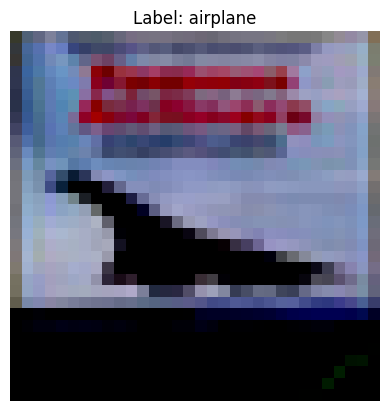

In [13]:
# Load the best model with batch normalization
model_with_bn.load_state_dict(torch.load("best_model_bn.pth"))
model_with_bn.eval()

# Loading a sample test image from the dataset
test_image, test_label = test_dataset[3] # Choosing [3] as a random index
test_image = test_image.unsqueeze(0).to(device)

# Visualizing the test image
print("Visualizing Test Image:")
plt.imshow(test_image.squeeze(0).permute(1, 2, 0).cpu())
plt.title(f"Label: {test_dataset.classes[test_label]}")
plt.axis("off")
plt.show()

### Visualize Feature Maps

To visualize the feature map, I referred to the guidance from a [Medium article by Deepesh Deepak](https://medium.com/@deepeshdeepakdd2/cnn-visualization-techniques-feature-maps-gradient-ascent-aec4f4aaf5bd), where he demonstrates the use of a hook function to extract and visualize feature maps in a CNN.

Visualizing Feature Maps for Layers 1, 2, and 3:


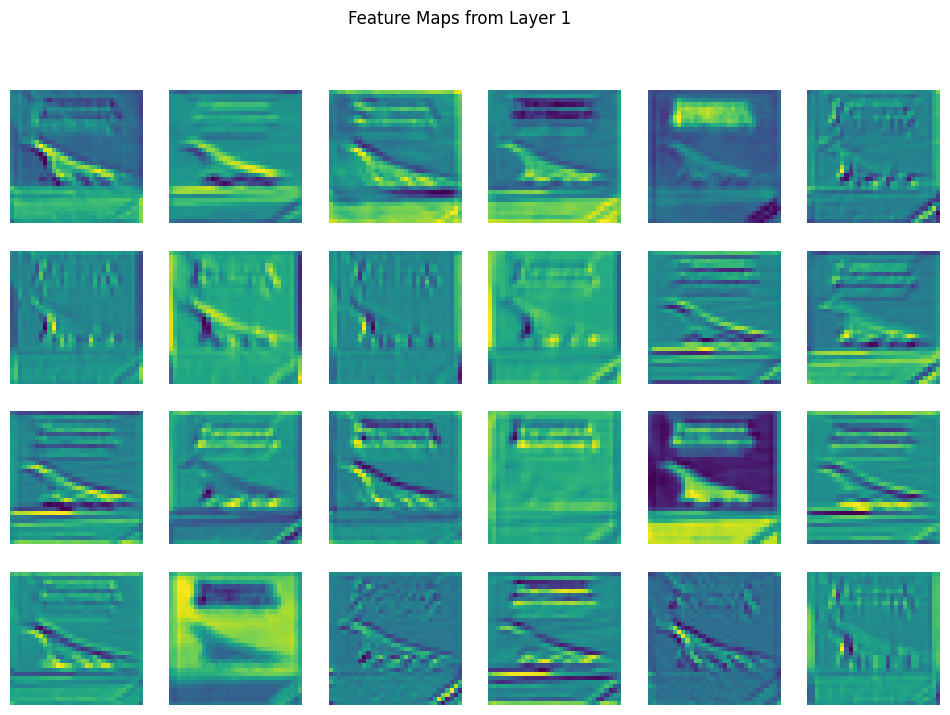

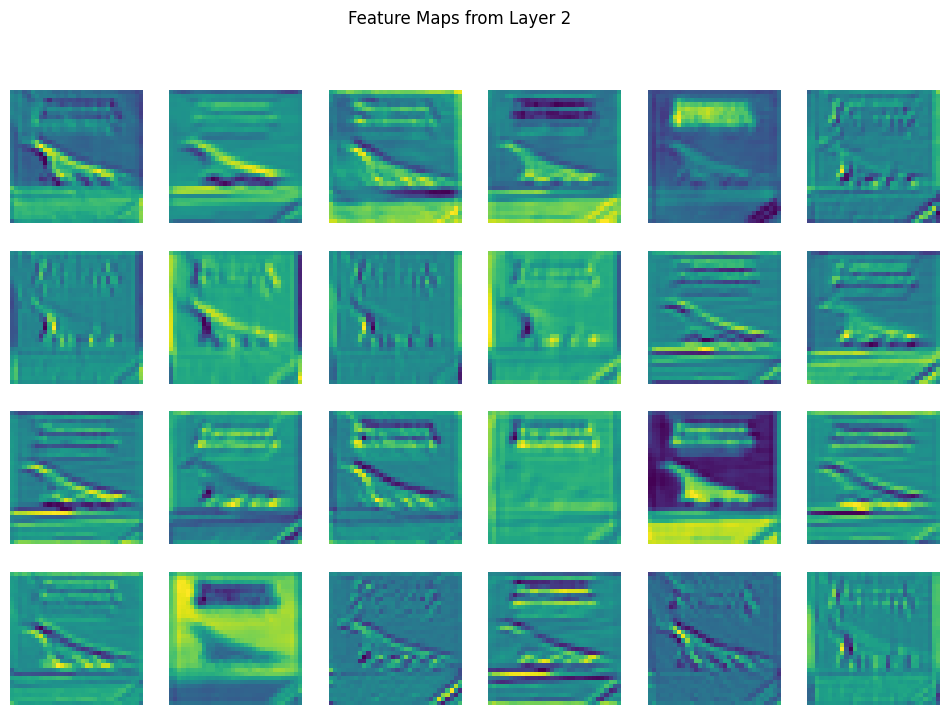

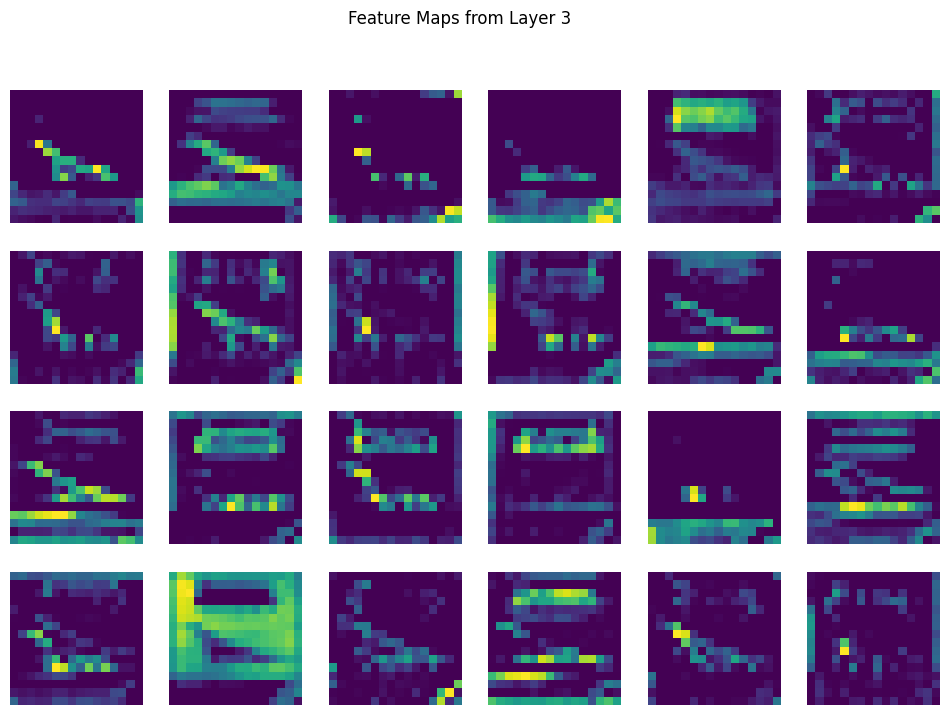

In [10]:
import matplotlib.pyplot as plt
import torch

# Function to visualize feature maps
def visualize_feature_maps(model_with_bn, image, layer_nums):
    for layer_num in layer_nums:
        feature_maps = []

        # Hook function
        def hook_fn(module, input, output):
            feature_maps.append(output)

        # Select the layer and register the hook
        layer = list(model_with_bn.children())[layer_num]
        handle = layer.register_forward_hook(hook_fn)

        # Perform a forward pass
        model_with_bn.eval()
        with torch.inference_mode():
            _ = model_with_bn(image)

        # Plot the feature maps
        layer_output = feature_maps[0].squeeze().cpu()
        rows, cols = 4, 6
        fig = plt.figure(figsize=(12, 8))
        for i in range(1, (rows * cols) + 1):
            if i > layer_output.shape[0]:
                break
            feature_map = layer_output[i - 1].numpy()
            fig.add_subplot(rows, cols, i)
            plt.imshow(feature_map, cmap='viridis')
            plt.axis("off")
        plt.suptitle(f"Feature Maps from Layer {layer_num + 1}")
        plt.show()

        # Remove the hook
        handle.remove()

# Visualize feature maps
print("Visualizing Feature Maps for Layers 1, 2, and 3:")
layer_nums = [0, 1, 2]
visualize_feature_maps(model_with_bn, test_image, layer_nums)
